In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score
from haversine import haversine, Unit

In [10]:
def run_model(DataFrame):
    df_xvalues = DataFrame[['start_lng', 'start_lat', 'end_lng', 'end_lat']]
    x_train, x_test, y_train, y_test = train_test_split(df_xvalues, DataFrame['total_time'],random_state=0)
    model = LinearRegression()
    model.fit(x_train, y_train)
    predict = model.predict(x_test)
    return predict, y_test

In [11]:
def rmse(predictions, y_test):
    new_lst = []
    for a, b in zip(predictions, y_test):
        new_lst.append((a - b) ** 2)
    value = sum(new_lst) / len(new_lst)
    return value ** 0.5

In [12]:
def calc_distance(row):
    start = (row['start_lat'], row['start_lng'])
    end = (row['end_lat'], row['end_lng'])
    return haversine(start, end, unit=Unit.METERS)

In [13]:
def harv_model(DataFrame):
    x_values = DataFrame[['harvensine_dist']]
    x_train, x_test, y_train, y_test = train_test_split(x_values, DataFrame['total_time'],random_state=0)
    model = LinearRegression()
    model.fit(x_train, y_train)
    predict = model.predict(x_test)
    return predict, y_test

In [18]:
df = pd.read_csv('all_bike_data.csv')
# adding columns for 
df['total_time'] = pd.to_datetime(df['ended_at']) - pd.to_datetime(df['started_at'])
df['total_time'] = df['total_time'].dt.total_seconds()
df['day_of_week'] = pd.to_datetime(df['started_at']).dt.dayofweek
df['harvensine_dist'] = df.apply(calc_distance, axis=1)
df.dropna(inplace=True)
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,total_time,day_of_week,harvensine_dist
0,68B619BB8F5938F6,classic_bike,2024-06-27 15:40:33.729,2024-06-27 15:44:55.420,Cambridge Main Library at Broadway / Trowbridg...,M32013,Central Sq Post Office / Cambridge City Hall a...,M32012,42.373379,-71.111075,42.366426,-71.105495,member,261.691,3,898.822807
1,01F1130C0E47858C,classic_bike,2024-06-23 10:15:12.915,2024-06-23 10:22:34.652,Cambridge Main Library at Broadway / Trowbridg...,M32013,Harvard Square at Brattle St / Eliot St,M32017,42.373379,-71.111075,42.373329,-71.120986,member,441.737,6,814.183518
2,BE120AAA9C5ADEE2,classic_bike,2024-06-21 08:49:22.787,2024-06-21 08:59:18.465,Cambridge Main Library at Broadway / Trowbridg...,M32013,Galileo Galilei Way at Fulkerson St/Binney St,M32078,42.373379,-71.111075,42.366420,-71.088542,member,595.678,4,2006.353136
3,BF4646DF4296D41E,classic_bike,2024-06-13 19:47:23.335,2024-06-13 19:56:53.372,O'Brien Highway at First Street,M32090,Cambridge Dept. of Public Works -147 Hampshire...,M32052,42.370982,-71.076638,42.371197,-71.097599,member,570.037,3,1722.094449
4,2162825F11FF90B4,classic_bike,2024-06-07 17:20:19.809,2024-06-07 17:28:43.494,Cambridge Main Library at Broadway / Trowbridg...,M32013,Mass Ave at Albany St,M32061,42.373379,-71.111075,42.361358,-71.096703,member,503.685,4,1783.473714


In [19]:
# problem 1
prediction, y_test = run_model(df)
rmse(prediction, y_test)

1891.8073939001015

In [20]:
#problem 2
df_member = df[df['member_casual'] == 'member']
prediction, y_test = run_model(df_member)
rmse(prediction, y_test)

1301.9164704054792

In [21]:
# problem 3
df_3 = df[(df['total_time'] < 3600) & (df['member_casual'] == 'member') &
(df['day_of_week'] != 5) & (df['day_of_week'] != 6) & 
(df['rideable_type'] == 'classic_bike')]
prediction, y_test = run_model(df_3)
rmse(prediction, y_test)

522.7842740110001

In [29]:
# problem 4
predictions, y_test = harv_model(df_3)
# rmse 
rmse(predictions, y_test)

361.8117069716103

In [23]:
scalar = StandardScaler()
df['harvensine_norm'] = scalar.fit_transform(df[['harvensine_dist']])
df['member_nominal'] = df['member_casual'].map({'member': 0, 'casual': 1})
df['rideable_type'] = df['rideable_type'].map({'classic_bike': 0, 'electric_bike': 1})
df['time_scaled'] = [1 if time > 1800 else 0 for time in df['total_time']]

In [24]:
# number 5
x = df[['member_nominal', 'rideable_type', 'harvensine_norm']]
x_train, x_test, y_train, y_test = train_test_split(x, df['time_scaled'], random_state=0)
model = LogisticRegression()
model.fit(x_train, y_train)
prediction = model.predict(x_test)
accuracy = accuracy_score(y_test, prediction)
recall = recall_score(y_test, prediction)
accuracy, recall

(0.8912992534565297, 0.1240701754385965)

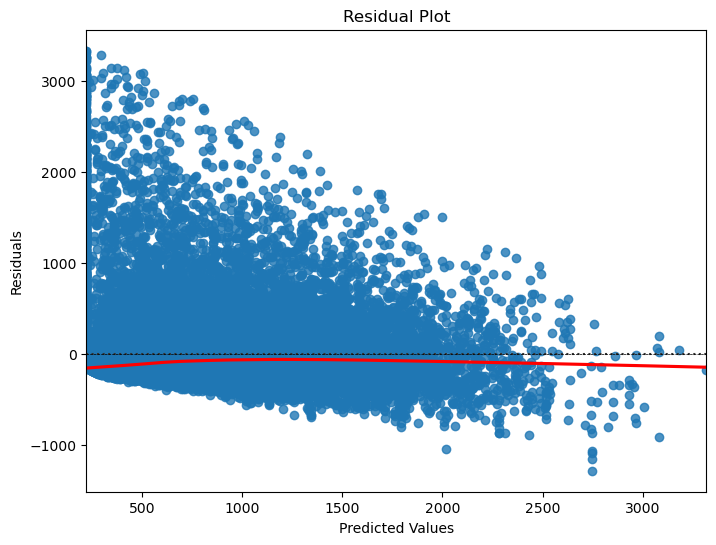

In [30]:
# Calculate residuals
residuals = y_test - predictions  # Assuming `predictions` are the model predictions

# Plot residuals
plt.figure(figsize=(8, 6))
sns.residplot(x=predictions, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(0, color="black", linestyle="--", linewidth=0.5)
plt.show()

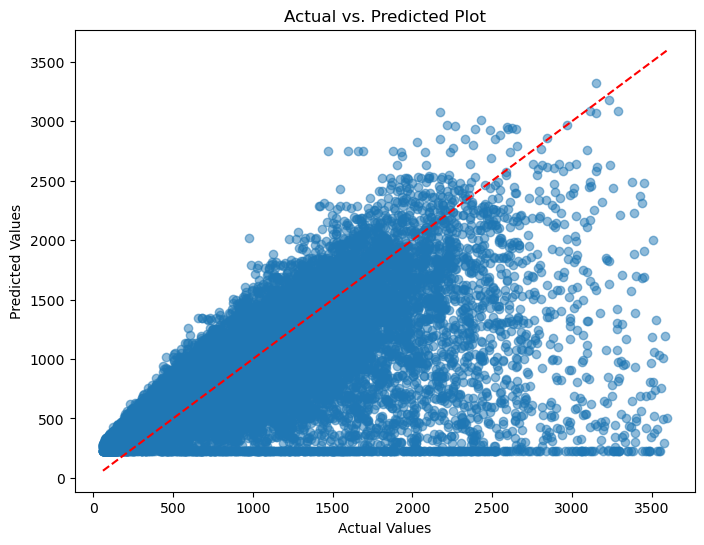

In [31]:
# actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Plot")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line for reference
plt.show()